In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing

c:\Users\ksyuk\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('own_data.csv', parse_dates=True, index_col = 'date')
data.head()

,numb
date,
2016-01-05 08:00:00,123.430000
2016-01-05 16:00:00,125.839996
2016-01-06 08:00:00,125.239998
2016-01-06 16:00:00,119.980003
2016-01-07 08:00:00,116.379997


In [3]:
data.isnull().sum()

numb    0
dtype: int64

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
numb,722.0,121.901676,5.41845,105.629997,118.662503,123.220001,125.435001,132.770004


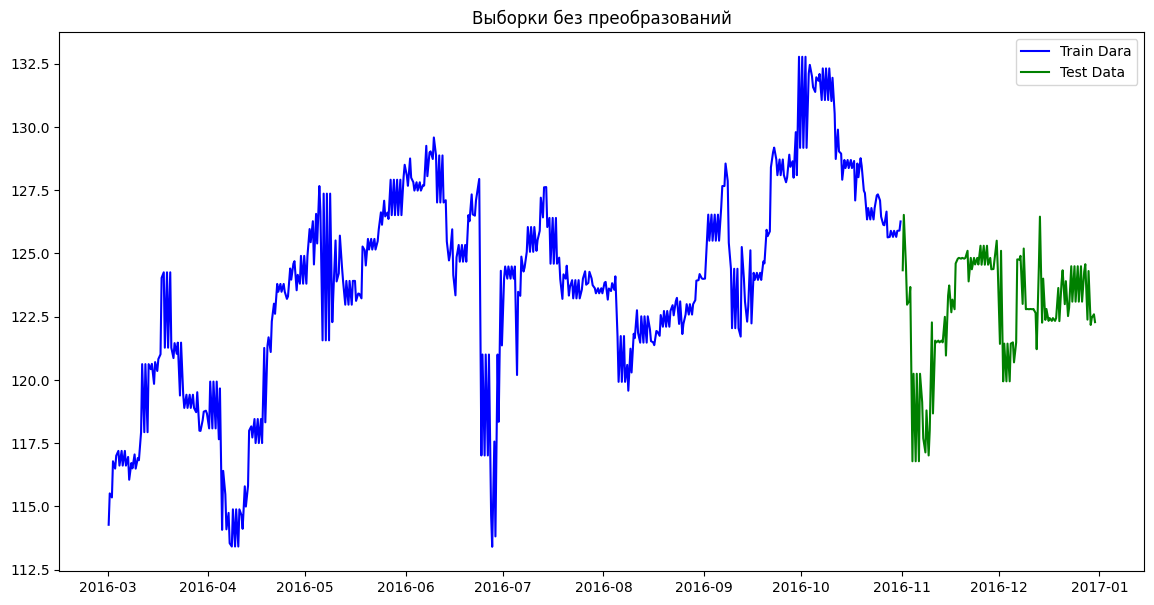

In [5]:
start_date = '2016-03-01'
mid_date = '2016-11-01'
data_all = data[data.index >= start_date]
train_f = data_all[data_all.index < mid_date]
test_f = data_all[data_all.index >= mid_date]


plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

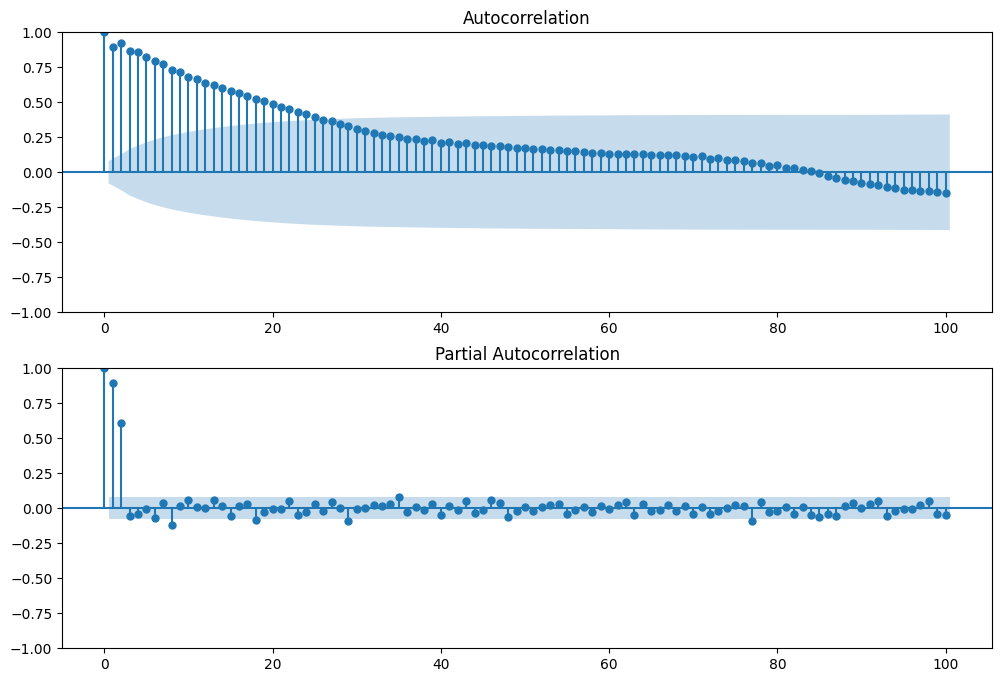

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(data_all, ax=ax1, lags=100)
sm.graphics.tsa.plot_pacf(data_all, ax=ax2, lags=100)
plt.show()

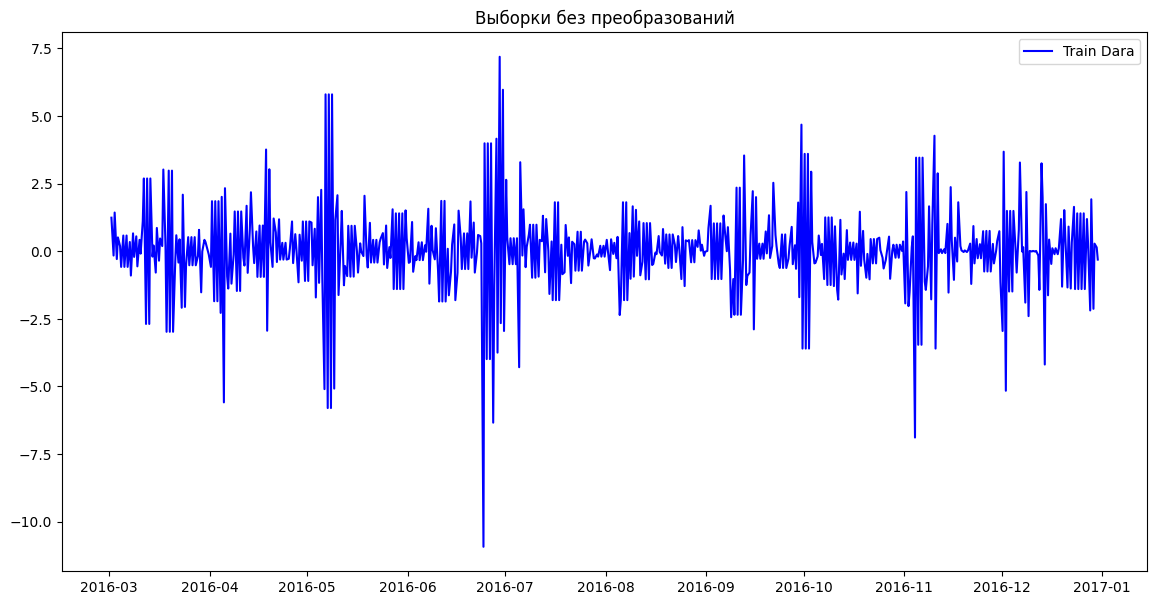

In [7]:
data_fix = data_all.diff().dropna()

plt.figure(figsize=(14, 7))
plt.plot(data_fix.index, data_fix, label='Train Dara', color='b')
#plt.plot(.index, test_f, label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

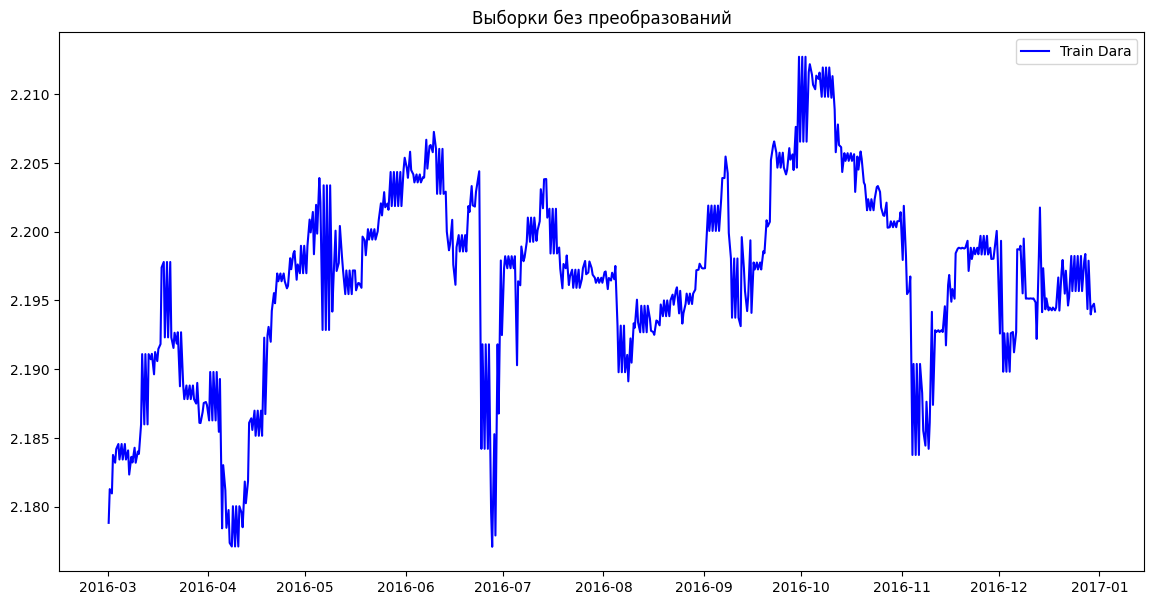

In [74]:
from sklearn.preprocessing import QuantileTransformer

data_log_transformed = np.log1p(data_all)

data_sqrt_transformed = np.sqrt(data_log_transformed )
data_transformed = pd.DataFrame(data_sqrt_transformed, columns=data_all.columns, index=data_all.index)

plt.figure(figsize=(14, 7))
plt.plot(data_transformed.index, data_transformed, label='Train Dara', color='b')
#plt.plot(.index, test_f, label='Test Data', color='g')
plt.title('Выборки без преобразований')
plt.legend()
plt.show()

In [8]:
train_fix = data_fix[data_fix.index < mid_date]
test_fix = data_fix[data_fix.index >= mid_date]

In [9]:
train_fix

,numb
date,
2016-03-01 16:00:00,1.240005
2016-03-02 08:00:00,-0.160004
2016-03-02 16:00:00,1.430001
2016-03-03 08:00:00,-0.290001
2016-03-03 16:00:00,0.510002
...,...
2016-10-29 16:00:00,0.239997
2016-10-30 08:00:00,-0.239997
2016-10-30 16:00:00,0.239997


In [10]:
adf_test = adfuller(data_fix)
print(f'p-value = {adf_test[1]}')
if adf_test[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

p-value = 7.269474265756933e-14
Ряд стационарен


In [11]:
from fbprophet import Prophet

model = Prophet()

# Обучение модели на данных
model.fit(data)

# Создание будущего временного ряда для прогнозирования
future = model.make_future_dataframe(periods=48)  # Прогноз на следующие 365 дней

# Генерация прогноза
forecast = model.predict(future)

# Визуализация прогноза
fig = model.plot(forecast)
plt.show()

ModuleNotFoundError: No module named 'fbprophet'

In [67]:
model_holt = ExponentialSmoothing(train_fix, damped_trend=False, trend=None, 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=22).fit()

forecast_holt_fix = model_holt.forecast(steps=len(test_f))

forecast_holt = train_f.iloc[-1].values[0] + forecast_holt_fix.cumsum()

# initial_value = train_f.iloc[-1].values[0]  # Преобразование последнего значения в скаляр
# forecast_holt = initial_value + forecast_holt_diff_2.reset_index(drop=True)

print(f'Final Forecast Holt:\n{forecast_holt}')

Final Forecast Holt:
489    126.027735
490    125.850467
491    126.499125
492    125.661422
493    125.542773
          ...    
604    128.312472
605    128.231049
606    128.167873
607    128.543349
608    128.360617
Length: 120, dtype: float64


C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [54]:
forecast_holt

489    126.027735
490    125.850467
491    126.499125
492    125.661422
493    125.542773
          ...    
604    128.312472
605    128.231049
606    128.167873
607    128.543349
608    128.360617
Length: 120, dtype: float64

In [55]:
mae_holt = mean_absolute_error(test_f, forecast_holt)
print(f'Holt-Winters MAE: {mae_holt}')

Holt-Winters MAE: 4.414805499614272


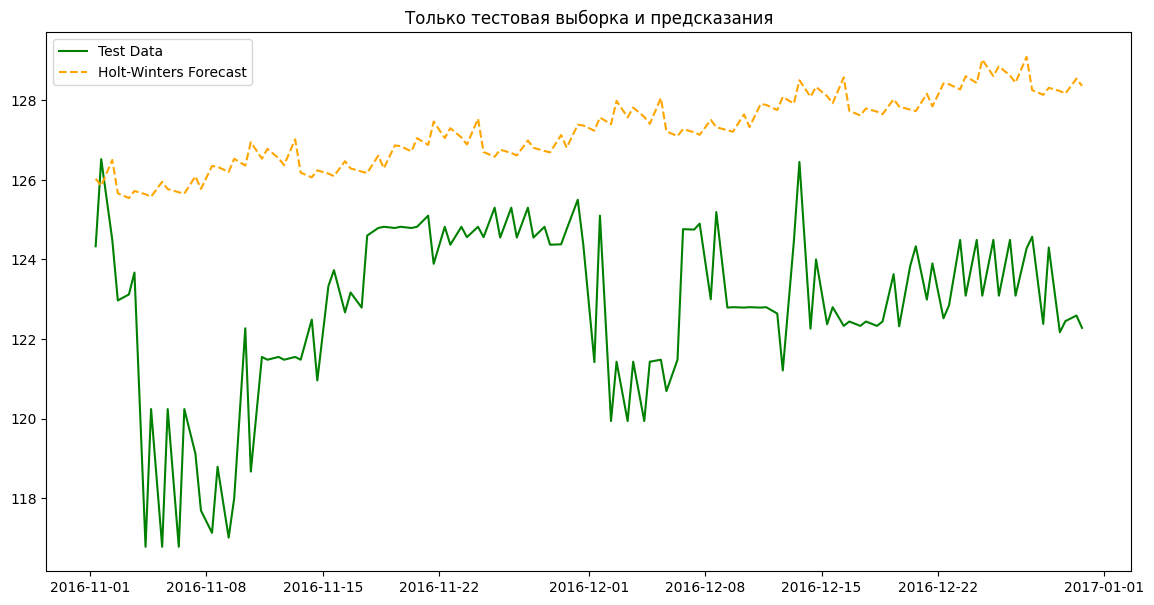

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title('Только тестовая выборка и предсказания')
plt.show()

In [7]:
model = ARIMA(train_fix, order=(13,1,15), seasonal_order=(1, 2, 3, 22))
model_fit = model.fit()

forecast_arima = model_fit.get_forecast(steps=len(test_f)).predicted_mean

# Визуализация {'p': 15, 'd': 2, 'q': 18, 'P': 4, 'D': 1, 'Q': 5}
plt.figure(figsize=(14, 7))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_arima, label='Arima Forecast', color='orange', linestyle='--')
plt.legend()
plt.show()

C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ksyuk\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


KeyboardInterrupt: 